In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import hydroeval as he

from CompressedSensingInterpolator import CompresedSensingInterpolator
from InterpolateHelperFunctions import *

site_names_list = ['BEN', 'BLI', 'BSL', 'CLE', 'CRB', 'DAI', 'DFF', 'DFL', 'DFM', 'DFU', 'HCL', 'HCN', 'HCS', 'IND', 'LAK', 'LDF', 'MIT', 'NEB', 'PBC', 'SBL', 'SFL', 'SHE', 'SHE (1)', 'SOL', 'SOL (1)', 'STR', 'TCU', 'TIE', 'WAN']
all_pressure_df = pd.read_csv("all_pressure.csv")

0.05299283524832164
0.4025155656890871


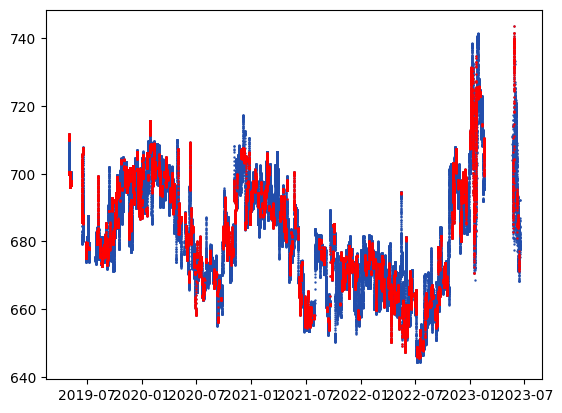

In [19]:
site_id = "BSL"
site_df = pd.DataFrame()
site_df[["datetime","pressure_hobo"]] = all_pressure_df[["datetime",site_id]]
site_df['datetime'] = pd.to_datetime(site_df['datetime'], format='%Y-%m-%d %H:%M:%S')
site_df = site_df[site_df['pressure_hobo'].notna()]
all_days = pd.date_range(site_df['datetime'].min(), site_df['datetime'].max(), freq='15min')
all_days = pd.DataFrame(all_days, columns=["datetime"])
site_df = all_days.merge(site_df, on='datetime', how='left')

#generating a test dataframe from our actual data. This function generate randomly indexed sequences of nas of random lengths
test_df = get_test_df(site_df)

In [3]:
down_sample_list = [10,15,20,30,40,50]
mv_avg_width_list = [1,2,3,4,5,6,7,8,9,10,15,20,30,40,50,75,100,150,200]

In [ ]:
metrics_list = []
#iterate through each site
for site_id in site_names_list:
    print(f"Working on site: {site_id}")

    try:
        
        site_df[["datetime","pressure_hobo"]] = all_pressure_df[["datetime",site_id]]
        site_df['datetime'] = pd.to_datetime(site_df['datetime'], format='%Y-%m-%d %H:%M:%S')
        site_df = site_df[site_df['pressure_hobo'].notna()]
        all_days = pd.date_range(site_df['datetime'].min(), site_df['datetime'].max(), freq='15min')
        all_days = pd.DataFrame(all_days, columns=["datetime"])
        site_df = all_days.merge(site_df, on='datetime', how='left')

        #generating a test dataframe from our actual data. This function generate randomly indexed sequences of nas of random lengths
        test_df = get_test_df(site_df)

        #iterate through different potential down sample values
        for down_sample_value in down_sample_list:

            sparse_joined_test_df = down_sample_and_interpolate_once(test_df,all_days,down_sample_value,'pressure_hobo')
            
            #iterate through different potential moving average window widths
            for width_value in mv_avg_width_list:
                filled_test_df = sparse_joined_test_df
                filled_test_df["pressure_combined_filled"] = filled_test_df["pressure_combined"].rolling(min_periods=1, center=True, window=width_value).mean()

                my_nse = he.evaluator(he.nse, filled_test_df["pressure_combined_filled"], filled_test_df["pressure_hobo"])
                my_pbias = he.evaluator(he.pbias, filled_test_df["pressure_combined_filled"], filled_test_df["pressure_hobo"])
                my_rmse = he.evaluator(he.rmse, filled_test_df["pressure_combined_filled"], filled_test_df["pressure_hobo"])
                
                #add metrics and identifiers to a list of dictionaries
                metrics_dict = (site_id,down_sample_value, width_value, my_nse, my_pbias, my_rmse)
                metrics_list.append(metrics_dict)

    except:
        print(f"Site: {site_id} did not work")

#transform metrics list into dataframe
metrics_df = pd.DataFrame(metrics_list, columns=["site","down_sampled_to", "mv_avg_width","nse","pbias","rmse"])
metrics_df

(array([  12.,    6.,    0.,   27.,   15.,   28.,   33.,   80.,  206.,
        2785.]),
 array([0.21306688, 0.29176019, 0.3704535 , 0.44914681, 0.52784013,
        0.60653344, 0.68522675, 0.76392006, 0.84261338, 0.92130669,
        1.        ]),
 <BarContainer object of 10 artists>)

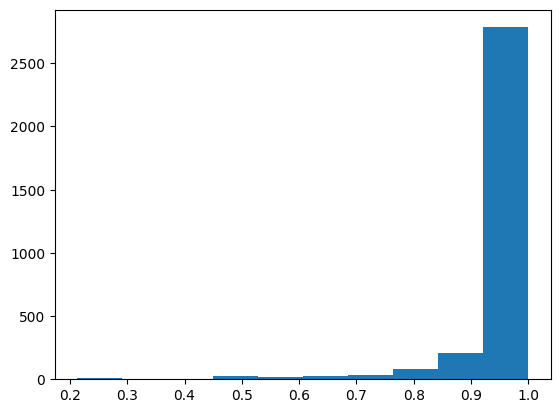

In [15]:
#metrics_df

plt.hist(x=metrics_df["nse"])

In [16]:
#fixing type for the metrics columns
metrics_df['nse'] = pd.to_numeric(metrics_df['nse'].str[0])
metrics_df['pbias'] = pd.to_numeric(metrics_df['pbias'].str[0])
metrics_df['rmse'] = pd.to_numeric(metrics_df['rmse'].str[0])

#the closer to 0 the better for percent bias, so taking the absolute value and then finding the minimum works here
metrics_df['pbias_abs'] = metrics_df['pbias'].abs()

AttributeError: Can only use .str accessor with string values!

In [17]:
#making a dataframe for each metric that shows which parameters resulted in the best score for each site
nse_maxs_df = metrics_df.loc[metrics_df.groupby('site')['nse'].idxmax().values]
pbias_mins_df = metrics_df.loc[metrics_df.groupby('site')['pbias_abs'].idxmin().values]
rmse_mins_df = metrics_df.loc[metrics_df.groupby('site')['rmse'].idxmin().values]


In [18]:
nse_maxs_df

,site,down_sampled_to,mv_avg_width,nse,pbias,rmse,pbias_abs
0,BEN,10,1,1.0,0.0,0.0,0.0
114,BLI,10,1,1.0,0.0,0.0,0.0
228,BSL,10,1,1.0,0.0,0.0,0.0
342,CLE,10,1,1.0,0.0,0.0,0.0
456,CRB,10,1,1.0,0.0,0.0,0.0
570,DAI,10,1,1.0,0.0,0.0,0.0
684,DFF,10,1,1.0,0.0,0.0,0.0
798,DFL,10,1,1.0,0.0,0.0,0.0
912,DFM,10,1,1.0,0.0,0.0,0.0
1026,DFU,10,1,1.0,0.0,0.0,0.0


In [9]:
rmse_mins_df

,site,down_sampled_to,mv_avg_width,nse,pbias,rmse,pbias_abs
0,BEN,10,1,1.0,0.0,0.0,0.0
114,BLI,10,1,1.0,0.0,0.0,0.0
228,BSL,10,1,1.0,0.0,0.0,0.0
342,CLE,10,1,1.0,0.0,0.0,0.0
456,CRB,10,1,1.0,0.0,0.0,0.0
570,DAI,10,1,1.0,0.0,0.0,0.0
684,DFF,10,1,1.0,0.0,0.0,0.0
798,DFL,10,1,1.0,0.0,0.0,0.0
912,DFM,10,1,1.0,0.0,0.0,0.0
1026,DFU,10,1,1.0,0.0,0.0,0.0


In [10]:
pbias_mins_df

,site,down_sampled_to,mv_avg_width,nse,pbias,rmse,pbias_abs
0,BEN,10,1,1.0,0.0,0.0,0.0
114,BLI,10,1,1.0,0.0,0.0,0.0
228,BSL,10,1,1.0,0.0,0.0,0.0
342,CLE,10,1,1.0,0.0,0.0,0.0
456,CRB,10,1,1.0,0.0,0.0,0.0
570,DAI,10,1,1.0,0.0,0.0,0.0
684,DFF,10,1,1.0,0.0,0.0,0.0
798,DFL,10,1,1.0,0.0,0.0,0.0
912,DFM,10,1,1.0,0.0,0.0,0.0
1026,DFU,10,1,1.0,0.0,0.0,0.0
